## Code in this notebook has been written referencing this website 
https://www.clawpack.org/marching_front.html#marching-front 

In [ ]:
#set up environment and imported modules
import os
os.environ['CLAW'] = '/Users/anitamiddleton/Documents/python/clawpack'
os.environ['FC'] = 'gfortran'

dir = os.path.join('Users/anitamiddleton/Documents/python/tsunami_proj/scratch')
%pylab inline

from clawpack.visclaw import colormaps, plottools, geoplot
import matplotlib.pyplot as plt
# create ruled region
from clawpack.amrclaw import region_tools
from clawpack.geoclaw import topotools, marching_front, fgmax_tools
from clawpack.visclaw.plottools import pcolorcells
from matplotlib import colors 
import numpy as np
%matplotlib widget

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/clawpack/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['norm', 'colormaps']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


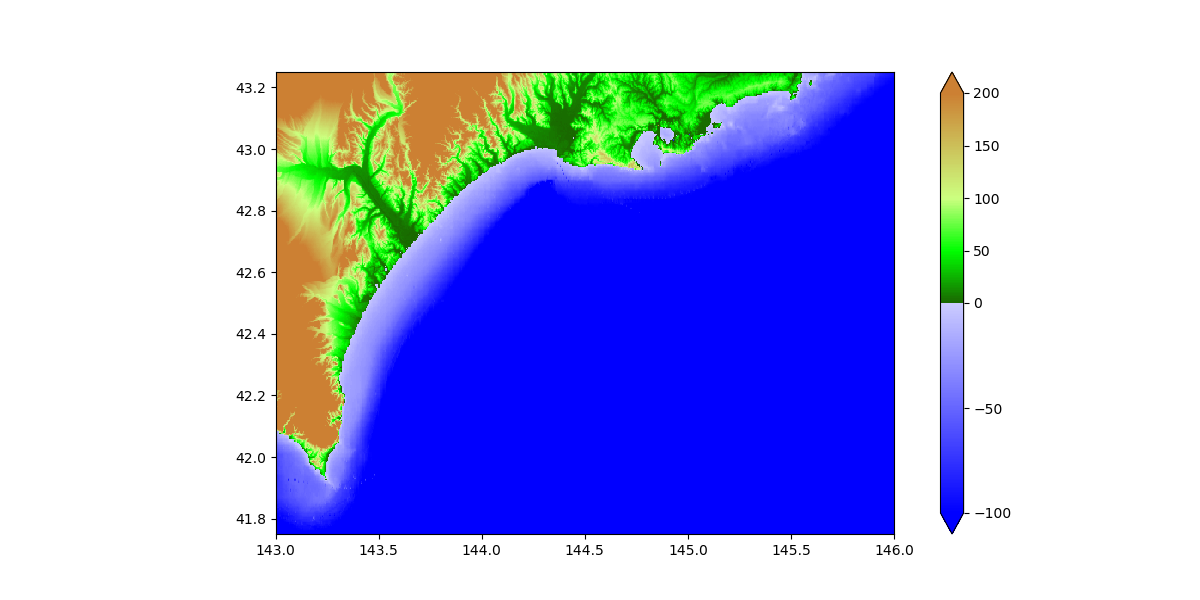

In [ ]:
# read in the topography file that the fgmax region is based on
# the topo file is not the entire island of hokkaido, because having the coastline wrap all the 
# way around causes problems with the ruled rectangle creation 

topo_path = os.path.join(dir, 'curr_topo.tt3')
topo = topotools.Topography(topo_path, topo_type=3)
topo = topo.crop(filter_region=[143, 146, 41.75, 43.25])

zmin = -100.
zmax = 200.

land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})

sea_cmap = colormaps.make_colormap({ 0.0:[0,0,1], 1.:[.8,.8,1]})

cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)    

cmap_sea_dry = colormaps.make_colormap({ 0.0:[1.0,0.7,0.7], 1.:[1.0,0.7,0.7]})
cmap_dry, norm_dry = colormaps.add_colormaps((land_cmap, cmap_sea_dry),
                                     data_limits=(zmin,zmax),
                                     data_break=0.)

plt.close('all')
if 1:
    figure(figsize=(12,6))
    pcolorcells(topo.X, topo.Y, topo.Z, cmap=cmap, norm=norm)
    colorbar(extend='both')
    gca().set_aspect(1./cos(48*pi/180.))

Selecting points with Z1 = 1, Z2 = 1e+10, max_iters=259200
Done after 267 iterations with 259200 points chosen
Selecting points with Z1 = 0.1, Z2 = 15, max_iters=259200
Done after 0 iterations with 259200 points chosen


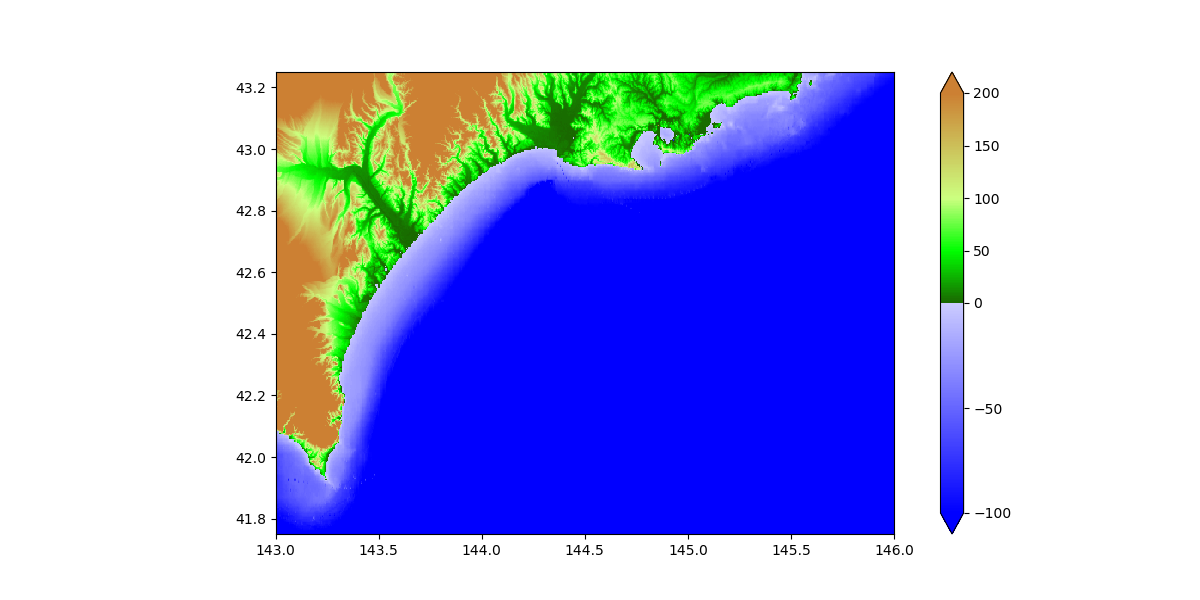

In [35]:
# choose fgmax points to monitor by selecting all points, regardless of topography, within 20 points of the coastline
# as determined by sea level being 0

pts_chosen = marching_front.select_by_flooding(topo.Z, Z1=1, Z2=1e10, max_iters=None)
Zmasked = np.ma.masked_array(topo.Z, np.logical_not(pts_chosen))

# add on points that are between 0 and 15 meters elevation along the coastline to the original set
pts_chosen = marching_front.select_by_flooding(topo.Z, Z1=0.1, Z2=15.,
                                               prev_pts_chosen=pts_chosen,
                                               max_iters=None)

Zmasked = np.ma.masked_array(topo.Z, np.logical_not(pts_chosen))

figure(figsize=(12,6))
pcolorcells(topo.X, topo.Y, Zmasked, cmap=cmap, norm=norm)
colorbar(extend='both')
gca().set_aspect(1./cos(48*pi/180.))

Selecting points with Z1 = 0, Z2 = -1e+10, max_iters=259200
Done after 446 iterations with 259200 points chosen


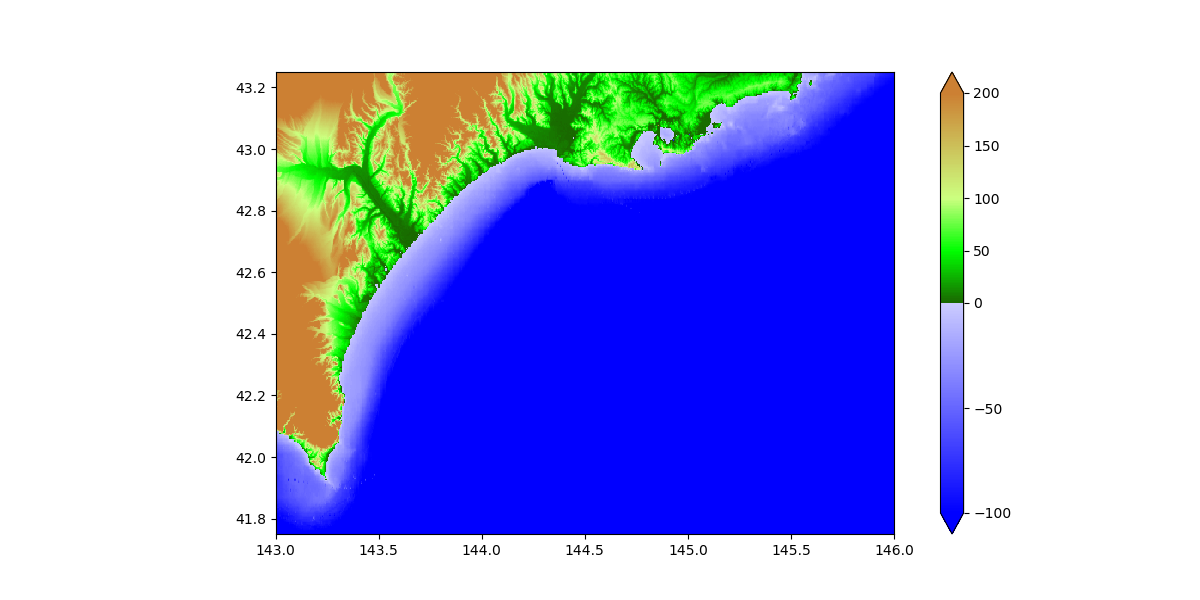

In [36]:
# select points that are above -15 meters elevation, 
# this selects all dry topography points, as well as shallow bathymetry data (above -15m)
pts_chosen_shallow = marching_front.select_by_flooding(topo.Z, Z1=0, Z2=-1.e10, max_iters=None)
Zshallow = np.ma.masked_array(topo.Z, np.logical_not(pts_chosen_shallow))

# find the intersection of the onshore coastal points from the previous code cell
# with the shallow bathymetry points found above 
# for a complete set of fgmax points along the coast and in the shallow waters around them
pts_chosen_nearshore = np.logical_and(pts_chosen, pts_chosen_shallow)
Znearshore = np.ma.masked_array(topo.Z, np.logical_not(pts_chosen_nearshore))

figure(figsize=(12,6))
pcolorcells(topo.X, topo.Y, Znearshore, cmap=cmap, norm=norm)
colorbar(extend='both')
gca().set_aspect(1./cos(48*pi/180.))

In [37]:
# write the file to save the fgmax point data
fname_fgmax_mask = 'scratch/fgmax_pts_topostyle.txt'
topo_fgmax_mask = topotools.Topography()
topo_fgmax_mask._x = topo.x
topo_fgmax_mask._y = topo.y
topo_fgmax_mask._Z = np.where(pts_chosen, 1, 0)  # change boolean to 1/0
topo_fgmax_mask.generate_2d_coordinates()

topo_fgmax_mask.write(fname_fgmax_mask, topo_type=3, Z_format='%1i')
print('Created %s' % fname_fgmax_mask)

Created scratch/fgmax_pts_topostyle.txt


Extending rectangles to cover grid cells
RuledRectangle covers 259921 grid points


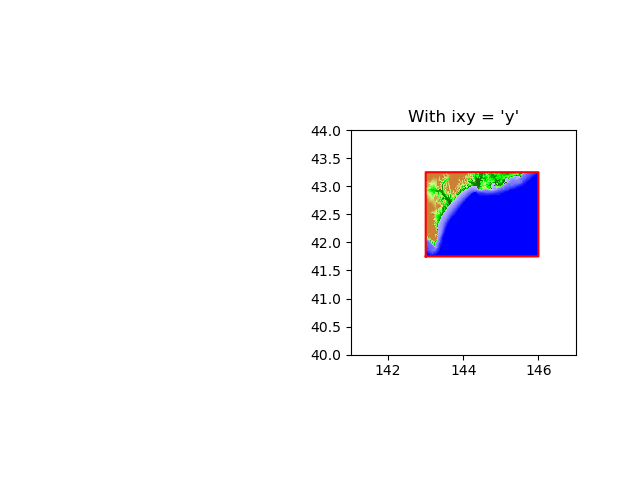

In [39]:
# create the ruled rectangle used to force refinement around the fgmax points
# ixy = 'y' because 'x' artifically cropped the eastern limb of hokkaido in a way that isn't realistic
plt.close('all')
subplot(122)
rr = region_tools.ruledrectangle_covering_selected_points(topo.X, topo.Y, pts_chosen,
                                                          ixy='y', method=0,
                                                          padding=0, verbose=True)
xv,yv = rr.vertices()
rr.write('scratch/RuledRectangle_fgmax.txt')

pcolorcells(topo.X, topo.Y, Znearshore, cmap=cmap, norm=norm)
axis([141, 147, 40, 44])
gca().set_aspect(1./cos(48*pi/180.))
plot(xv, yv, 'r')
title("With ixy = 'y'")
plt.show()